# Non-linear curve fitting with `Scipy`

This notebook shows a simple example of fitting a non-linear curve (in this case, expotential) to a set of $X$ and $Y$ data. Statsmodels is strongest for linear curve fitting (as well as time series analysis).  But `Scipy` might be your tool of choice if the relationship you are fitting is non-linear.  We're going to use `curve_fit` from Scipy -- see more here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

We'll first import our libaries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit # this is the scipy function we'll use to do our curve fitting

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
# plt.rcParams['font.family'] = 'Helvetica'

In [2]:
# Generate synthetic data for the example
np.random.seed(1999)
X = np.linspace(0, 1, 50)

# specify the true parameters for the fit
a = 2
b = 2.5

Y = a * np.exp(b * X) + np.random.normal(0, 1, size=X.shape)

Let's take a quick look at what our data now look like:

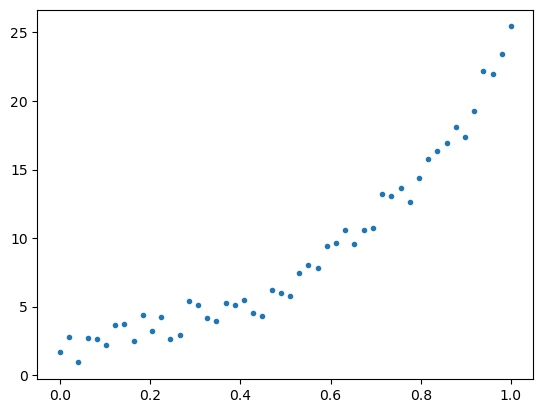

In [3]:
plt.plot(X,Y,'.')
plt.show()

In order to use `curve_fit`, we need to specify the structure of the model.  We can do this as a function with a very simple model structure:

In [4]:
# Define the exponential function we want to fit using curve_fit
def exponential_function(x, a, b):
    return a * np.exp(b * x)

In the above, the function accepts the predictor (x), and two parameters of the exponential function.  Note that this function just looks like something we could call to create an exponential data series (in fact, as we did above), but it can also be passed as a function to Scipy's `curve_fit` to specify the functional form of the curve we want to fit!  

We are now ready to call our curve fitting routine.  We have the definition of our curve as a function and we have X and Y.  Take another look at [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) and review the parameters and options.  We could provide an initial guess ($p0$) or bound the parameters (e.g. require them to be positive or negative), for instance.  For now we'll make a simple call.  The function returns **popt**, which will contain the values for the parameters ($a$ and $b$ in this case), as well as **pcov2**, which is the covariance of the parameters, which can be used in turn to calculate standard deviations on the parameter estimates, see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [7]:
# Use curve_fit to find the best fit parameters (a, b)
popt, pcov = curve_fit(exponential_function, X, Y)  # p0 are the initial guesses for a and b
print(popt) # first output is the estimated a and b parameters, the second array are the 
print(pcov)

[1.89480627 2.56582856]
[[ 0.00821767 -0.00504282]
 [-0.00504282  0.00324318]]


Note that our estimates for $a$ and $b$ are pretty close -- we underestimate $a$ (2 vs. estimated 1.89) and get quite close to $b$ (2.5 vs. 2.56 estimated).

In order to create estimated values from our model fit, we call `exponential_function` again:

In [8]:
# Generate the predicted Y values using the output from the fitted model
Y_pred = exponential_function(X, *popt) # pre-pending the * lets us pass the 2 coefficients at the same time, without splitting them up into popt[0] and popt[1]

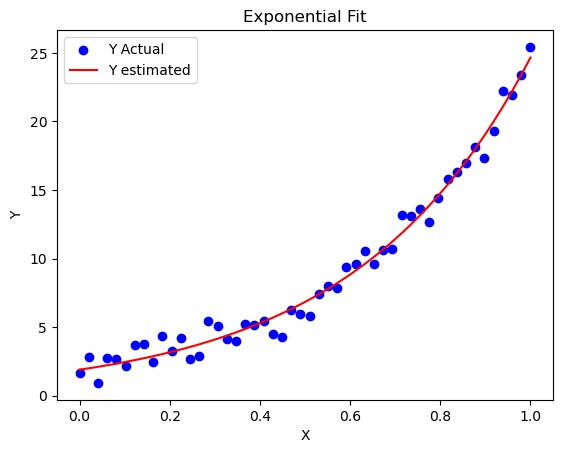

In [9]:
# Plot the original data and the fitted curve
plt.scatter(X, Y, label='Y Actual', color='blue')
plt.plot(X, Y_pred, label='Y estimated', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exponential Fit')
plt.show()

### Extra: a non-parametric approach to uncertainty estimatation for exponential fitting

In [10]:
# Standard deviations (uncertainties) of the parameters from the covariance matrix
perr = np.sqrt(np.diag(pcov))

# non-parametric sampling - create n_samples of a multivariante normal draw with out parameters and our covariance
n_samples = 1000
parameter_samples = np.random.multivariate_normal(popt, pcov, size=n_samples)

# Initialize empty list to hold the results of the sampling loop
Y_samples = []

# Loop over each set of parameters 
for params in parameter_samples:
    Y_sample = exponential_function(X, *params) # Compute the predicted Y values for the current set of parameters
    Y_samples.append(Y_sample) # Append the result to the Y_samples list

# Convert the list of samples into a NumPy array
Y_samples = np.array(Y_samples)

# alternatively, you could do the entire look above in one line comprehension:
# Y_samples = np.array([exponential_function(X, *params) for params in parameter_samples])

# Calculate the 95% confidence interval 
Y_lower = np.percentile(Y_samples, 2.5, axis=0) # gets the 2.5%th value from the distribution 
Y_upper = np.percentile(Y_samples, 97.5, axis=0) # gets the 97.5%th value from the distribution - collectively then this spans 95% of the values in the distribution 

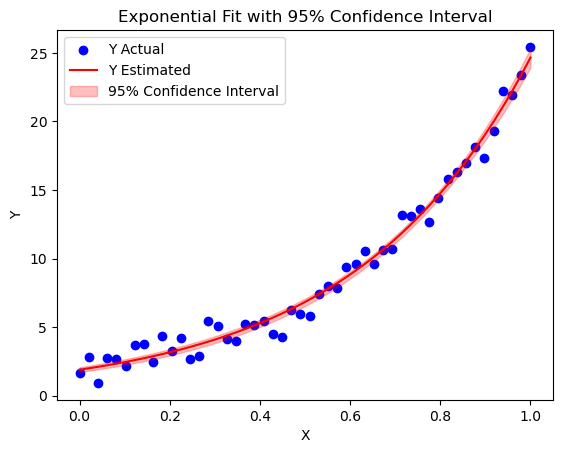

In [11]:
# Plot the data, the fit, and the confidence interval
plt.scatter(X, Y, label='Y Actual', color='blue')
plt.plot(X, Y_pred, label='Y Estimated', color='red')
plt.fill_between(X, Y_lower, Y_upper, color='red', alpha=0.25, label='95% Confidence Interval')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exponential Fit with 95% Confidence Interval')
plt.show()